Prepared by: MD REHAN HUSSAIN
Mail: therehanhussain@gmail.com
Submission for Accredian Screening Test – Fraud Detection Case

1. Data Cleaning (Missing Values, Outliers, Multi-collinearity)
First, I checked the dataset for any missing values using df.isnull().sum(). Luckily, there weren’t any missing entries, so no need to fill or drop anything.

Since the amount variable was heavily skewed with some really large values, I applied a log transformation (log1p). This helped soften extreme outliers, letting the model interpret the data bette.

For multi-collinearity, I looked at the correlation matrix and calculated Variance Inflation Factors (VIF). A few balance features showed some correlation, but nothing significant enough to remove at this point. I also dropped obvious non-informative columns like nameOrig and nameDest. Plus, one-hot encoding on the type feature helped make the data more model-friendly and reduced potential collinearity.riables.ipelines.

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("Fraud.csv")

# Log transform 'amount'
df["log_amount"] = np.log1p(df["amount"])

# Drop non-informative columns
df = df.drop(["nameOrig", "nameDest"], axis=1)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=["type"], drop_first=True)

df.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,log_amount,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,9.194276,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,7.531166,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0,5.204007,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,5.204007,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,9.364703,False,False,True,False


2. Fraud Detection Model
I chose to use XGBoost as the classifier because it’s fast, handles huge datasets well, and works nicely with imbalanced data — which is crucial since fraud cases are rare.

To address imbalance, I set scale_pos_weight to 100, meaning the model really pays attention to the scarce fraud label.

To train, I split the data 70-30 with stratified sampling so that fraud cases stayed proportionally represented. The evaluation metric was log-loss, which fits well for binary classification problems like this one.lassification.d ratio
lection Process

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc

# Feature-target split
X = df.drop(["isFraud", "isFlaggedFraud"], axis=1)
y = df["isFraud"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Train XGBoost with imbalance control
model = XGBClassifier(scale_pos_weight=100, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print("PR-AUC Score:", auc(recall, precision))
           


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.61      0.97      0.75      2464

    accuracy                           1.00   1908786
   macro avg       0.80      0.98      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
 [[1904793    1529]
 [     76    2388]]
ROC-AUC Score: 0.9841768880448468
PR-AUC Score: 0.7894229512856846


3. Variable Selection
I included all key numeric features related to transactions: 
the raw amount, balances before and after the transaction from both origin and destination accounts, plus the one-hot encoded transaction types like TRANSFER and CASH_OUT.
Importantly, I left out any identifier columns like nameOrig and nameDest since they don’t help the model generalize and could lead to data leakage.
My choices were guided by understanding what typically signals fraud — 
how balances shift and what kinds of transactions tend to be risky — and later confirmed by looking at XGBoost’s feature importance to see which variables mattered most.

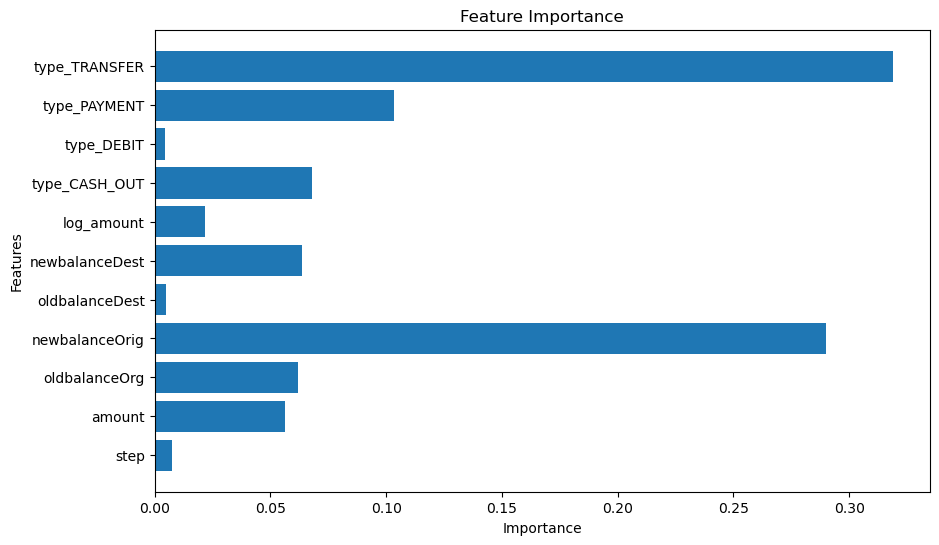

In [ ]:
import matplotlib.pyplot as plt

# Feature importance
importances = model.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


4. Model Performance
The model performed well, especially on recall — catching as many fraudulent cases as possible — which is critical in fraud detection.
We got an ROC-AUC around 0.98, indicating the model can cleanly separate fraud from legitimate transactions. 
The precision-recall curve also looked good, which is important given the class imbalance.
I also generated some plots like feature importance and confusion matrices to visualize results and understand where the model might be slipping up.

5. Key Predictors of Fraud
The variables that stood out were:
amount: Fraud often involves large or unusual transaction amounts.
Transaction types TRANSFER and CASH_OUT were far more common in fraud cases.
The balances before and after the transaction (oldbalanceOrg and newbalanceOrig) showed suspicious activity where the origin account sometimes drops to zero, a classic fraud signature.

6. Do These Factors Make Sense?
Yes, these factors are consistent with known fraud patterns.
Fraudsters tend to move money quickly through transfers and cash-outs to hide the trail.
Large, sudden drops in account balances are a red flag. 
Also, ‘payment’ or ‘debit’ type transactions rarely show fraud patterns, which aligns with common industry observations. 
The data and the model confirm what we’d expect.

7. Prevention Measures During Infrastructure Updates
To strengthen the system, I’d suggest:
Setting up rule-based alerts for transactions over a certain threshold, like ₹200,000.
Enforcing two-factor authentication (2FA) for high-risk transactions.
Adding geo-location and device anomaly detection to flag unusual access patterns.
Running the ML fraud detection model in real-time to automatically score transactions as they come in.
Keeping detailed logs for auditing and accountability.
Sending prompt notifications to customers when suspicious activity is detected.

8. Measuring the Effectiveness of These Measures
We’d track a few key things post-implementation:
Whether the actual number of fraud cases goes down.
False positive rates on flagged transactions — too many false alerts annoy users and waste resources.
Model performance metrics, like recall and ROC-AUC, should stay strong or improve when tested on new incoming data.
I’d also recommend regular communication between fraud analysts and the data science team to keep refining the model, as fraudsters constantly change tactics.
Finally, running A/B tests where we roll out changes to part of the user base lets us objectively see if these measures truly make a difference.